<a href="https://colab.research.google.com/github/david-j-cox/Man-vs-Machine/blob/master/Predicting_Next_Pitch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reading in the data and isolating a player we want to mimic their decision-making

In [ ]:
# Basic packages used in most scripts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from google.colab import files
# files.upload()
from google.colab import drive
drive.mount('/content/gdrive')
%cd './gdrive/My Drive/GME & MLB/Data_and_Fits'

Mounted at /content/gdrive
/content/gdrive/My Drive/GME & MLB/Data_and_Fits


In [ ]:
# Read in file
data_raw = pd.read_csv("all_pitches_08_19.csv").drop(['Unnamed: 0'], axis=1)
# data_raw = data_raw.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
data = data_raw.copy()
data[::300000] # Take a look at every 300,000 row of the df

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (44,88,89) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,...,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment
0,FF,2019-09-29,94.9,-2.3738,5.1379,Ian Kennedy,570731,453178,field_out,hit_into_play,NaN,NaN,NaN,NaN,3.0,Jonathan Schoop pops out to second baseman Eri...,R,R,R,KC,MIN,X,4.0,popup,1,1,2019,-0.909700,1.197200,0.3906,3.1900,NaN,NaN,NaN,2,9,Top,134.20,170.51,NaN,...,-16.6055,3.5400,1.6800,NaN,80.0,69.0,95.087,2430.0,6.245,565782,453178,664926.0,656811.0,625510.0,596144.0,600858.0,643436.0,621433.0,641531.0,54.2545,0.002,0.000,0.0,1.0,0.0,0.0,3.0,67,3,4-Seam Fastball,4,4,4,4,4,4,4,4,Standard,Standard
300000,FF,6/12/2013,92.7,NaN,NaN,Ubaldo Jimenez,595777,434622,single,hit_into_play_no_out,NaN,NaN,NaN,NaN,5.0,Jurickson Profar singles on a line drive to ri...,R,L,R,TEX,CLE,X,9.0,line_drive,3,2,2013,-1.000000,1.200000,0.2300,2.6600,NaN,NaN,NaN,0,3,Bot,170.68,120.48,NaN,...,-19.0500,3.2500,1.5000,NaN,NaN,NaN,NaN,NaN,NaN,347723,434622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.9,NaN,1.0,0.0,NaN,25,6,4-Seam Fastball,1,3,1,3,3,1,1,3,NaN,NaN
600000,FF,8/5/2015,98.2,-2.2600,6.4000,Taijuan Walker,518934,592836,NaN,ball,NaN,NaN,NaN,NaN,11.0,NaN,R,R,R,COL,SEA,B,NaN,NaN,2,2,2015,-0.500000,0.900000,-1.0000,5.0600,NaN,NaN,NaN,2,6,Bot,NaN,NaN,NaN,...,-22.1420,3.7300,1.7400,NaN,NaN,NaN,98.800,2159.0,6.800,415263,592836,572287.0,444432.0,429664.0,572122.0,606466.0,429711.0,457706.0,443558.0,53.7400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52,5,4-Seam Fastball,3,3,3,3,3,3,3,3,Standard,Standard
900000,FF,2019-04-14,95.1,-2.4165,5.8449,Jacob Barnes,641355,606930,strikeout,called_strike,NaN,NaN,NaN,NaN,14.0,Cody Bellinger called out on strikes.,R,L,R,LAD,MIL,S,2.0,NaN,2,2,2019,-0.353100,1.198000,0.5948,1.4827,NaN,NaN,NaN,1,6,Bot,NaN,NaN,NaN,...,-14.9366,3.8740,1.7203,NaN,NaN,NaN,96.485,2332.0,6.791,565808,606930,518735.0,542583.0,519058.0,543768.0,606115.0,592325.0,456715.0,519346.0,53.7083,NaN,NaN,0.0,1.0,0.0,0.0,NaN,50,5,4-Seam Fastball,7,0,7,0,0,7,7,0,Infield shift,Standard
1200000,FF,2015-06-23,92.9,-0.6400,5.7700,Al Alburquerque,596019,456379,field_out,hit_into_play,NaN,NaN,NaN,NaN,1.0,Francisco Lindor lines out to center fielder A...,R,L,R,CLE,DET,X,8.0,line_drive,2,1,2015,-0.900000,1.500000,-0.7200,2.8500,570482.0,543401.0,NaN,2,7,Bot,113.87,93.28,NaN,...,-15.4010,3.3100,1.5300,279.0,101.5,13.0,91.100,2409.0,5.200,414715,456379,543510.0,408234.0,435079.0,592206.0,461865.0,493316.0,543238.0,434658.0,55.2400,0.733,0.764,0.0,1.0,0.0,0.0,4.0,62,4,4-Seam Fastball,1,7,1,7,7,1,1,7,Standard,Strategic
1500000,SL,7/24/2012,90.6,NaN,NaN,Clayton Kershaw,279577,477132,NaN,blocked_ball,NaN,NaN,NaN,NaN,60.0,NaN,R,R,L,STL,LAD,B,NaN,NaN,0,2,2012,-0.600000,0.900000,-1.0600,0.4400,501896.0,518614.0,425794.0,2,6,Bot,NaN,NaN,NaN,...,-23.7420,3.1800,1.4800,NaN,NaN,NaN,NaN,NaN,NaN,319183,477132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53,3,Slider,4,2,4,2,2,4,4,2,NaN,NaN
1800000,SL,8/28/2013,76.7,NaN,NaN,Darren Oliver,407489,119984,NaN,called_strike,NaN,NaN,NaN,NaN,29.0,NaN,R,L,L,TOR,NYY,S,NaN,NaN,0,1,2013,-1.200000,-0.200000,0.6300,2.5700,NaN,NaN,NaN,1,9,Top,NaN,NaN,NaN,...,-35.4640,3.6200,1.6200,NaN,NaN,NaN,NaN,NaN,NaN,348729,119984,Na

In [ ]:
# Look at the top 10 players with the most observations
player_list = data['player_name'].value_counts()[:10]
player_list

Justin Verlander    42244
Jon Lester          39379
Zack Greinke        37627
Cole Hamels         37281
Max Scherzer        37243
James Shields       36082
Felix Hernandez     34855
Clayton Kershaw     34377
CC Sabathia         33943
Gio Gonzalez        32399
Name: player_name, dtype: int64

In [ ]:
# Subset the dataframe to focus on just Justin Verlander
df = data[data['player_name']=='Justin Verlander']
df = df.dropna(subset=['pitch_name'])
len(df)

41937

In [ ]:
# Look at all the different pitch types in the dataframe
print(df['pitch_type'].unique())
df['pitch_name'].unique()

['FF' 'CU' 'FC' 'SL' 'CH' 'FT' 'IN' 'PO']


array(['4-Seam Fastball', 'Curveball', 'Cutter', 'Slider', 'Changeup',
       '2-Seam Fastball', 'Intentional Ball', 'Pitch Out'], dtype=object)

In [ ]:
# Look at all the different outcome events
df['description'].unique()

array(['swinging_strike', 'foul', 'hit_into_play', 'hit_into_play_score',
       'ball', 'swinging_strike_blocked', 'called_strike',
       'hit_into_play_no_out', 'foul_tip', 'blocked_ball', 'hit_by_pitch',
       'foul_bunt', 'intent_ball', 'missed_bunt', 'pitchout',
       'swinging_pitchout'], dtype=object)

In [ ]:
# The df is currently arranged in the order of most recent to oldest. We need to reverse that. 
df = df.loc[::-1]

In [ ]:
# Save df for easier access at later point
df = df.reset_index(drop=True)
df.to_csv('verlander.csv')

In [ ]:
# If picking up fresh
raw_df = pd.read_csv('verlander.csv').drop(['Unnamed: 0'], axis=1)
df = raw_df.copy()
df[::10000]

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (44,88,89) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,...,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment
0,CH,2008-03-31,84.2,NaN,NaN,Justin Verlander,430203,434378,NaN,ball,NaN,NaN,NaN,NaN,7.0,NaN,R,L,R,DET,KC,B,NaN,NaN,0,0,2008,-2.6000,1.0000,-0.5100,1.9300,NaN,NaN,NaN,0,1,Top,NaN,NaN,NaN,...,-23.6200,3.2200,1.6500,NaN,NaN,NaN,NaN,NaN,NaN,233765,434378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,Changeup,0,0,0,0,0,0,0,0,NaN,NaN
10000,FF,2019-07-24,94.6,-1.5041,7.0073,Justin Verlander,657656,434378,NaN,foul,NaN,NaN,NaN,NaN,6.0,NaN,R,R,R,HOU,OAK,S,NaN,NaN,2,1,2019,-0.8376,1.8515,0.3939,2.5836,NaN,NaN,NaN,1,4,Top,NaN,NaN,NaN,...,-7.1906,3.1107,1.4800,158.0,65.3,56.7,93.558,2642.0,5.967,565658,434378,455139.0,493329.0,514888.0,608324.0,664702.0,488726.0,543807.0,502210.0,54.5325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26,4,4-Seam Fastball,2,1,1,2,1,2,1,2,Standard,Standard
20000,FF,2012-06-24,95.6,NaN,NaN,Justin Verlander,457705,434378,field_out,hit_into_play,NaN,NaN,NaN,NaN,33.0,Andrew McCutchen flies out to right fielder Qu...,R,R,R,PIT,DET,X,9.0,fly_ball,3,2,2012,-0.8000,1.8000,0.8800,2.5400,NaN,NaN,NaN,0,4,Bot,195.78,103.41,NaN,...,-10.8610,3.4700,1.6200,NaN,NaN,NaN,NaN,NaN,NaN,318807,434378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,28,6,4-Seam Fastball,0,2,0,2,2,0,0,2,NaN,NaN
30000,SL,2015-06-30,85.3,-2.1700,6.8400,Justin Verlander,435522,434378,NaN,foul,NaN,NaN,NaN,NaN,6.0,NaN,R,L,R,DET,PIT,S,NaN,NaN,0,1,2015,0.0000,0.8000,0.3600,2.7700,NaN,NaN,NaN,2,6,Top,NaN,NaN,NaN,...,-25.3740,3.6400,1.7000,NaN,NaN,NaN,84.800,2508.0,5.900,414815,434378,543510.0,408234.0,435079.0,592206.0,578428.0,493316.0,543238.0,502110.0,54.5600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49,2,Slider,1,3,3,1,3,1,3,1,Standard,Standard
40000,FF,2017-05-30,93.1,-2.4585,6.5218,Justin Verlander,444876,434378,NaN,swinging_strike,NaN,NaN,NaN,NaN,7.0,NaN,R,R,R,KC,DET,S,NaN,NaN,0,0,2017,-1.9669,1.1101,-0.6202,1.2203,NaN,NaN,NaN,0,1,Bot,NaN,NaN,NaN,...,-16.9417,3.1638,1.3058,NaN,NaN,NaN,92.388,2498.0,5.930,490879,434378,543308.0,408234.0,553988.0,592206.0,578428.0,457708.0,592444.0,502110.0,54.5709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,1,4-Seam Fastball,0,0,0,0,0,0,0,0,Standard,Standard


In [ ]:
# Reduce the df to only the columns we need for our experiment
df = df[['game_date',  'player_name', 'batter', 'stand', 'home_team', 'away_team',\
               'inning', 'inning_topbot', 'bat_score', 'fld_score', 'at_bat_number', \
               'balls', 'strikes', 'outs_when_up', 'on_3b', 'on_2b', 'on_1b', 'pitch_number', \
               'if_fielding_alignment', 'of_fielding_alignment', 'pitch_type', \
               'description', 'events', 'des', 'post_bat_score', 'post_fld_score',]]

In [ ]:
# Drop rows where we don't know what the pitch was - kind of critical for this experiment. 
df = df.dropna(subset=['pitch_type'])

In [ ]:
# Create lists of which pitches fall into which categories
hrd_strt = ['FF', 'FT', 'FC', 'PO']
hrd_brkng = ['SL']
sft_strt = ['CH', 'IB']
sft_brkng = ['CU']

In [ ]:
# Add pitch categories to df
pitch_cat = []
for i in range(len(df)):
  if df['pitch_type'][i] in hrd_strt:
    pitch_cat.append('hs')
  elif df['pitch_type'][i] in hrd_brkng:
    pitch_cat.append('hb')
  elif df['pitch_type'][i] in sft_strt:
    pitch_cat.append('ss')
  elif df['pitch_type'][i] in sft_brkng:
    pitch_cat.append('sb')
  else:
    pitch_cat.append('un')

df['pitch_cat'] = pitch_cat

In [ ]:
# Handle missing values from other features
df['on_3b'] = df['on_3b'].fillna(value=0)
df['on_2b'] = df['on_2b'].fillna(value=0)
df['on_1b'] = df['on_1b'].fillna(value=0)
df['if_fielding_alignment'] = df['if_fielding_alignment'].fillna(value='Standard')
df['of_fielding_alignment'] = df['of_fielding_alignment'].fillna(value='Standard')
df['events'] = df['events'].fillna(value='at_bat_ongoing')
df['des'] = df['des'].fillna(value='at_bat_ongoing')

In [ ]:
# Check unique values in each feature to make sure there are no missing values
# and that each feature is of the same type. 
for i in list(df):
  print(i, "\n", df[i].unique(), "\n")

game_date 
 ['2008-03-31' '2008-04-06' '2008-04-12' '2008-04-17' '2008-04-22'
 '2008-04-27' '2008-05-03' '2008-05-08' '2008-05-14' '2008-05-20'
 '2008-05-25' '2008-05-31' '2008-06-06' '2008-06-11' '2008-06-16'
 '2008-06-22' '2008-06-28' '2008-07-03' '2008-07-08' '2008-07-13'
 '2008-07-20' '2008-07-26' '2008-07-31' '2008-08-06' '2008-08-11'
 '2008-08-16' '2008-08-22' '2008-08-27' '2008-09-01' '2008-09-06'
 '2008-09-14' '2008-09-20' '2008-09-26' '2009-04-06' '2009-04-11'
 '2009-04-17' '2009-04-22' '2009-04-27' '2009-05-03' '2009-05-08'
 '2009-05-14' '2009-05-20' '2009-05-25' '2009-05-30' '2009-06-05'
 '2009-06-10' '2009-06-16' '2009-06-21' '2009-06-26' '2009-07-01'
 '2009-07-07' '2009-07-12' '2009-07-18' '2009-07-24' '2009-07-29'
 '2009-08-03' '2009-08-08' '2009-08-13' '2009-08-19' '2009-08-24'
 '2009-08-30' '2009-09-04' '2009-09-09' '2009-09-14' '2009-09-19'
 '2009-09-24' '2009-09-29' '2009-10-04' '2017-09-05' '2017-09-12'
 '2017-09-17' '2017-09-22' '2017-09-27' '2019-03-28' '2019-04-02

In [ ]:
# Need to convert several category columns to numeric
df['stand'] = df['stand'].replace('R', 0)
df['stand'] = df['stand'].replace('L', 1)
df['inning_topbot'] = df['inning_topbot'].replace('Top', 0)
df['inning_topbot'] = df['inning_topbot'].replace('Bot', 1)
df['if_fielding_alignment'] = df['if_fielding_alignment'].replace('Standard', 0)
df['if_fielding_alignment'] = df['if_fielding_alignment'].replace('Infield shift', 1)
df['if_fielding_alignment'] = df['if_fielding_alignment'].replace('Strategic', 2)
df['of_fielding_alignment'] = df['of_fielding_alignment'].replace('Standard', 0)
df['of_fielding_alignment'] = df['of_fielding_alignment'].replace('4th outfielder', 1)
df['of_fielding_alignment'] = df['of_fielding_alignment'].replace('Strategic', 2)

In [146]:
# Change the specific player numbers to a boolean 1 or 0 for on base 
player_uniq = df['on_1b'].unique()
for i in ['on_1b', 'on_2b', 'on_3b']:
  for j in player_uniq:
    if j > 0:
      df[i] = df[i].replace(j, 1)

# Capturing molecular feedback

### After each pitch we need to capture molecular information on the contingencies operating on the pitch. Past research suggests using strikes/outs as reinforcement leads to good descriptions of pitch-type allocation of MLB pitchers (Cox et al., 2017; *in press*; Falligant et al., 2020). Thus, to capture molecular reinforcement, we can count the number of times a pitch type contacted a strike or out in the last 5 pitches. 

In [ ]:
# Create list of all Strike and out categories to serve as reinforcers
s_o = ['hit_into_play', 'foul','swinging_strike', 'swinging_strike_blocked', \
       'called_strike','foul_bunt', 'foul_tip', 'missed_bunt','swinging_pitchout', \
       'foul_pitchout', 'bunt_foul_tip', 'unknown_strike']

In [ ]:
# Add a feature to the df indicating whether the pitch contacted a strike/out
strike_out = []
for i in range(len(df)):
  if df['description'][i] in s_o:
    strike_out.append(1)
  else:
    strike_out.append(0)

df['strike_out'] = strike_out

In [ ]:
# Add feature to the df indicating whether the pitch contacts a strike/out in last 5 pitches thrown
last_5_hs = []
last_5_hb = []
last_5_ss = []
last_5_sb = []

for i in range(len(df)):
  sub_df = df.iloc[(i-5):i, :]
  sub_df = pd.crosstab(sub_df['pitch_cat'], sub_df['strike_out'])
  # Count hard and straight pitches that resulted in strike/out
  try:
    val = sub_df.loc['hs', 1]
    last_5_hs.append(val)
  except:
    last_5_hs.append(0)
  # Count hard and breaking pitches that resulted in strike/out
  try:
    val = sub_df.loc['hb', 1]
    last_5_hb.append(val)
  except:
    last_5_hb.append(0)
  # Count soft and straight pitches that resulted in strike/out
  try:
    val = sub_df.loc['ss', 1]
    last_5_ss.append(val)
  except:
    last_5_ss.append(0)
  # Count soft and breaking pitches that resulted in strike/out
  try:
    val = sub_df.loc['sb', 1]
    last_5_sb.append(val)
  except:
    last_5_sb.append(0)

In [ ]:
# Add to df
df['last_5_hs'] = last_5_hs
df['last_5_hb'] = last_5_hb
df['last_5_ss'] = last_5_ss
df['last_5_sb'] = last_5_sb

In [ ]:
# Save this df for future work
df.to_csv('verlander_operant.csv')

In [ ]:
# If picking up fresh
data = pd.read_csv('verlander_operant.csv')
df = data.copy()
df = df.drop(['Unnamed: 0'], axis=1)

# Capturing molar feedback

### The generalized matching equation (e.g., Baum, 1974) has been shown to describe relatively well the allocation of pitch-type in professional pitchers (*ibid*). For multi-alternative contexts (i.e., 3+ response options), one behavior is isolated as *Bi* and the rest are agrgegated into *Bo*. Thus, for each pitch type that the pitcher throws, we can calculate and update bias and sensitivity for that pitch type over the previous *N* pitches in the df. 

### We can make this tractable in two ways:

1.   Estimate matching paramaters using a rolling window of the previous *N* pitches. 
2.   Estimate matching paramaters using all pitches up to that point in time. 



In [ ]:
# Estimate params using rolling window of previous 500 pitches split into 5 bins of 100.
bias_hs = []
sensitivity_hs = []
vac_hs = []

for i in range(len(df)):
  if i < 500:
    bias_hs.append(np.nan)
    sensitivity_hs.append(np.nan)
    vac_hs.append(np.nan)
  else:
    try:
      # Separate last 500 pitches into bins of 100
      one = df.iloc[(i-500):(i-400), -6:-4]
      two = df.iloc[(i-400):(i-300), -6:-4]
      three = df.iloc[(i-300):(i-200), -6:-4]
      four = df.iloc[(i-200):(i-100), -6:-4]
      five = df.iloc[(i-100):(i), -6:-4]

      # Crosstab each so we can get counts of behavior and reinforcement
      one_df = pd.crosstab(one['pitch_cat'], one['strike_out'])
      two_df = pd.crosstab(two['pitch_cat'], two['strike_out'])
      three_df = pd.crosstab(three['pitch_cat'], three['strike_out'])
      four_df = pd.crosstab(four['pitch_cat'], four['strike_out'])
      five_df = pd.crosstab(five['pitch_cat'], five['strike_out'])

      # Create list of logged behaviors and logged reinforcers for hs as Bi
      log_bx = []
      log_sr = []
      # First 100
      hs_bx_1 = (one['pitch_cat'].values == 'hs').sum()    
      so_hs_1 = one_df.loc['hs', 1]
      so_oth_1 = one['strike_out'].sum() - so_hs_1
      log_bx.append(np.log(hs_bx_1/(100-hs_bx_1)))
      log_sr.append(np.log(so_hs_1/(so_oth_1)))
      # Second 100
      hs_bx_2 = (two['pitch_cat'].values == 'hs').sum()    
      so_hs_2 = two_df.loc['hs', 1]
      so_oth_2 = two['strike_out'].sum() - so_hs_2
      log_bx.append(np.log(hs_bx_2/(100-hs_bx_2)))
      log_sr.append(np.log(so_hs_2/(so_oth_2)))
      # Third 100
      hs_bx_3 = (three['pitch_cat'].values == 'hs').sum()    
      so_hs_3 = three_df.loc['hs', 1]
      so_oth_3 = three['strike_out'].sum() - so_hs_3
      log_bx.append(np.log(hs_bx_3/(100-hs_bx_3)))
      log_sr.append(np.log(so_hs_3/(so_oth_3)))
      # Fourth 100
      hs_bx_4 = (four['pitch_cat'].values == 'hs').sum()    
      so_hs_4 = four_df.loc['hs', 1]
      so_oth_4 = four['strike_out'].sum() - so_hs_4
      log_bx.append(np.log(hs_bx_4/(100-hs_bx_4)))
      log_sr.append(np.log(so_hs_4/(so_oth_4)))
      # Fifth 100
      hs_bx_5 = (five['pitch_cat'].values == 'hs').sum()    
      so_hs_5 = five_df.loc['hs', 1]
      so_oth_5 = five['strike_out'].sum() - so_hs_5
      log_bx.append(np.log(hs_bx_5/(100-hs_bx_5)))
      log_sr.append(np.log(so_hs_5/(so_oth_5)))      

      # Fit the GME and return the parameters
      sens, bias = np.polyfit(log_sr, log_bx, 1)
      corrmatSTR = np.corrcoef(log_sr, log_bx)
      r2 = (corrmatSTR[0,1])**2

      # Append to lists
      bias_hs.append(bias)
      sensitivity_hs.append(sens)
      vac_hs.append(r2)
    except:
      print("error")

# Add to df
df['bias_500'] = bias_hs
df['sens_500'] = sensitivity_hs
df['vac_500'] = vac_hs

In [147]:
# Save it
df.to_csv('verlander_operant.csv')

In [ ]:
# If picking up fresh
data = pd.read_csv('verlander_operant.csv').drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
df = data.copy()
df[::5000]

,game_date,player_name,batter,stand,home_team,away_team,inning,inning_topbot,bat_score,fld_score,at_bat_number,balls,strikes,outs_when_up,on_3b,on_2b,on_1b,pitch_number,if_fielding_alignment,of_fielding_alignment,pitch_type,description,events,des,post_bat_score,post_fld_score,strike_out,pitch_cat,last_5_hs,last_5_hb,last_5_ss,last_5_sb,bias_500,sens_500,vac_500
0,2008-03-31,Justin Verlander,430203,1,DET,KC,1,0,0,0,1,0,0,0,0.0,0.0,0.0,1,0,0,CH,ball,at_bat_ongoing,at_bat_ongoing,0,0,0,ss,0,0,0,0,NaN,NaN,NaN
5000,2009-06-21,Justin Verlander,429666,0,DET,MIL,4,0,1,0,28,2,1,2,0.0,0.0,451143.0,4,0,0,FF,hit_into_play,single,J. Hardy singles on a ground ball. Mat Game...,1,0,1,hs,2,0,0,0,0.242169,0.476157,0.443692
10000,2019-07-24,Justin Verlander,657656,0,HOU,OAK,4,0,1,2,26,2,1,1,0.0,0.0,0.0,4,0,0,FF,foul,at_bat_ongoing,at_bat_ongoing,1,2,1,hs,1,1,0,1,-0.095129,0.579453,0.397433
15000,2013-04-18,Justin Verlander,434604,0,SEA,DET,6,1,0,0,43,0,2,1,0.0,0.0,0.0,3,0,0,CU,ball,at_bat_ongoing,at_bat_ongoing,0,0,0,sb,2,1,1,0,0.011316,0.922764,0.478654
20000,2012-06-24,Justin Verlander,457705,0,PIT,DET,4,1,0,2,28,3,2,0,0.0,0.0,0.0,6,0,0,FF,hit_into_play,field_out,Andrew McCutchen flies out to right fielder Qu...,0,2,1,hs,2,0,0,0,0.042358,0.563872,0.843662
25000,2010-08-27,Justin Verlander,452252,1,TOR,DET,4,1,1,0,31,0,1,2,0.0,0.0,0.0,2,0,0,FF,ball,at_bat_ongoing,at_bat_ongoing,1,0,0,hs,1,1,2,0,0.009209,1.148485,0.968356
30000,2015-06-30,Justin Verlander,435522,1,DET,PIT,6,0,3,1,49,0,1,2,0.0,0.0,0.0,2,0,0,SL,foul,at_bat_ongoing,at_bat_ongoing,3,1,1,hb,3,0,1,0,0.077923,0.544640,0.816578
35000,2014-09-14,Justin Verlander,461815,1,DET,CLE,4,0,0,0,28,2,1,1,0.0,467793.0,543228.0,4,0,0,FF,swinging_strike,at_bat_ongoing,at_bat_ongoing,0,0,1,hs,0,0,1,0,0.270463,0.325532,0.352409
40000,2017-05-30,Justin Verlander,444876,0,KC,DET,1,1,0,0,6,0,0,0,0.0,0.0,0.0,1,0,0,FF,swinging_strike,at_bat_ongoing,at_bat_ongoing,0,0,1,hs,1,0,0,0,0.062444,0.792154,0.362157


# Building our environment for the artificial organism

### Before each pitch we need to capture the current environmental state. Important factors are likely to be: count, outs, position of runners on the basepath, inning, score, handedness of the batter, and the position of the batter in the opposing teams lineup. This can be captured as a vector in the following way:

*   [Balls, Strikes, Outs, Inning, Runner 1st, Runner 2nd, Runner 3rd, Home Score, Away Score, Pitcher Team (H or A), Batter Hand, Batter Position in Lineup]

### For simulations where we want to incorporate the molecular and molar information for the pitcher, we can tack combinations of those onto the end as such:


*   [Balls, Strikes, Outs, Inning, Runner 1st, Runner 2nd, Runner 3rd, Home Score, Away Score, Pitcher Team (H or A), Batter Hand, Batter Position in Lineup, Last 5 Strikes HS, Last 5 Strikes HB, Last 5 Strikes SS, Last 5 Strikes SB, Bias HS, Sensitivity HS, VAC HS]





In [ ]:
# Random pitch selection model as control
import random
correct = []
for i in range(len(df)):
  pitch = df['pitch_cat'][i]
  rand = random.random()
  if rand < 0.25:
    guess = 'hs'
  elif rand < 0.5:
    guess = 'hb'
  elif rand < 0.75:
    guess = 'ss'
  else:
    guess='sb'
  if pitch == guess:
    correct.append(1)
  else:
    correct.append(0)

percent_correct_random = []
for i in range(len(correct)):
  if i < 50:
    continue
  else:
    percent = round(sum(correct[(i-50):i])/50, 4)
    percent_correct_random.append(percent)

In [ ]:
# Always guess hard and straight as control model
correct = []
for i in range(len(df)):
  pitch = df['pitch_cat'][i]
  guess = 'hs'
  if pitch == guess:
    correct.append(1)
  else:
    correct.append(0)

percent_correct_hs = []
for i in range(len(correct)):
  if i < 50:
    continue
  else:
    percent = round(sum(correct[(i-50):i])/50, 4)
    percent_correct_hs.append(percent)

In [ ]:
d = {'random': percent_correct_random, 'always_hs':percent_correct_hs}
model_perf = pd.DataFrame(d)
model_perf

,random,always_hs
0,0.28,0.32
1,0.28,0.34
2,0.30,0.36
3,0.30,0.36
4,0.30,0.34
...,...,...
41882,0.24,0.58
41883,0.22,0.60
41884,0.22,0.58
41885,0.22,0.58


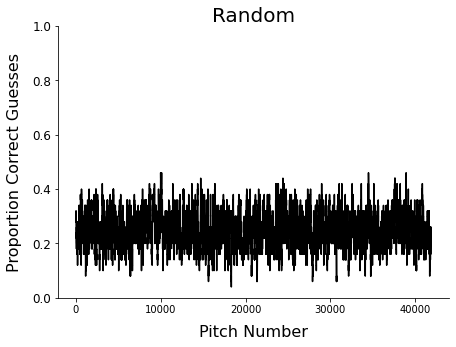

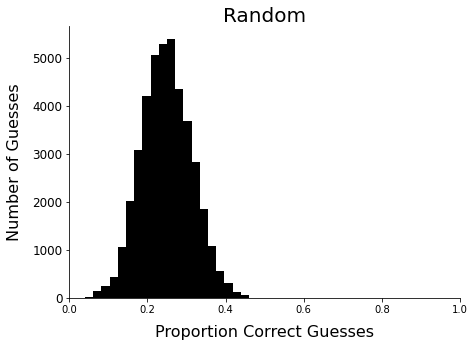

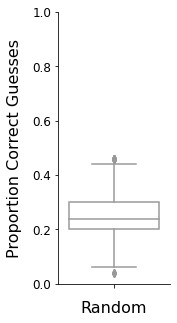

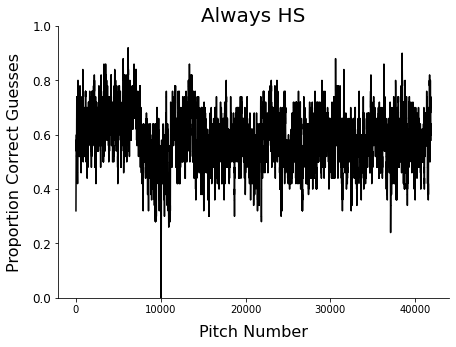

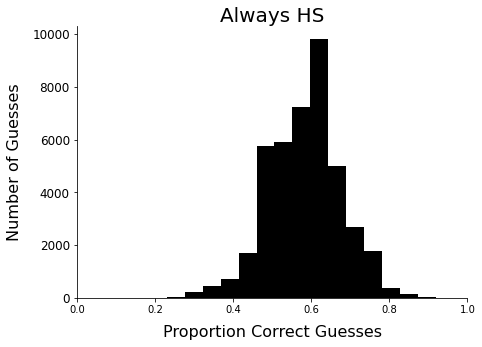

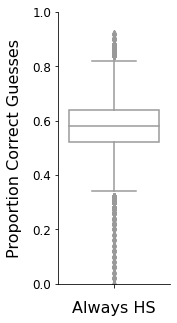

In [65]:
# Plots for control models
def plot_model_perf(df, title):
  # Lineplot
  f, ax = plt.subplots(figsize=(7, 5))
  plt.plot(df, color='k')
  ax.set_title(title, y=1.0, pad=-10, fontsize=20)
  plt.yticks(fontsize=12)
  plt.ylim(0, 1)
  plt.xlabel("Pitch Number", fontsize=16, labelpad=10)
  plt.ylabel("Proportion Correct Guesses", fontsize=16, labelpad=10)
  right_side = ax.spines["right"]
  right_side.set_visible(False)
  top = ax.spines["top"]
  top.set_visible(False)
  plt.show()

  # Histogram
  f, ax = plt.subplots(figsize=(7, 5))
  plt.hist(df, color='k', bins=20)
  ax.set_title(title, y=1.0, pad=-10, fontsize=20)
  plt.yticks(fontsize=12)
  plt.xlim(0, 1)
  plt.ylabel("Number of Guesses", fontsize=16, labelpad=10)
  plt.xlabel("Proportion Correct Guesses", fontsize=16, labelpad=10)
  right_side = ax.spines["right"]
  right_side.set_visible(False)
  top = ax.spines["top"]
  top.set_visible(False)
  plt.show()

  # Boxenplot
  f, ax = plt.subplots(figsize=(2, 5))
  sns.boxplot(y=df, color='w')
  plt.yticks(fontsize=12)
  plt.ylim(0, 1)
  plt.ylabel("Proportion Correct Guesses", fontsize=16, labelpad=10)
  plt.xlabel(title, fontsize=16, labelpad=10)
  right_side = ax.spines["right"]
  right_side.set_visible(False)
  top = ax.spines["top"]
  top.set_visible(False)
  plt.show()

# Plot them
plot_model_perf(model_perf['random'], "Random")
plot_model_perf(model_perf['always_hs'], "Always HS")

# Reinforcement Learning

In [158]:
# First we need to initialize a Q-table as a matrix of 576 rows by 4 columns
# stand = 0, 1 = 2
# balls = 0-3 = 4
# strikes = 0-2 = 3
# outs = 0-2 = 3
# on_3b = 0, 1 = 2
# on_2b = 0, 1 = 2
# on_1b = 0, 1 = 2
# 2*4*3*3*2*2*2 = 576
q_table = np.zeros([576, 4])
q_table = pd.DataFrame(q_table, columns=['hs', 'hb', 'ss', 'sb'])
q_table

,hs,hb,ss,sb
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0
...,...,...,...,...
571,0.0,0.0,0.0,0.0
572,0.0,0.0,0.0,0.0
573,0.0,0.0,0.0,0.0
574,0.0,0.0,0.0,0.0


In [128]:
# Create mapping between game context and state number
game_states = []
for l_r in [0, 1]:
  for b in [0, 1, 2, 3]:
    for s in [0, 1, 2]:
      for o in [0, 1, 2]:
        for f in [0, 1]:
          for scnd in [0, 1]:
            for t in [0, 1]:
              game_states.append([l_r, b, s, o, f, scnd, t])

game_states = pd.DataFrame(game_states, columns=['stand', 'balls', 'strikes', 
                                                 'outs', 'on_1b', 'on_2b', 'on_3b'])
game_states[::50] # take a peek

,stand,balls,strikes,outs,on_1b,on_2b,on_3b
0,0,0,0,0,0,0,0
50,0,0,2,0,0,1,0
100,0,1,1,0,1,0,0
150,0,2,0,0,1,1,0
200,0,2,2,1,0,0,0
250,0,3,1,1,0,1,0
300,1,0,0,1,1,0,0
350,1,0,2,1,1,1,0
400,1,1,1,2,0,0,0
450,1,2,0,2,0,1,0


In [149]:
# Create state_df to trim down just the game states associated with each pitch
state_df = df[['stand', 'balls', 'strikes', 'outs_when_up', 'on_1b', 'on_2b', 'on_3b']]
state_df = state_df.astype(int)
state_df

,stand,balls,strikes,outs_when_up,on_1b,on_2b,on_3b
0,1,0,0,0,0,0,0
1,0,0,0,1,0,0,0
2,0,0,1,1,0,0,0
3,0,1,1,1,0,0,0
4,0,1,2,1,0,0,0
...,...,...,...,...,...,...,...
41932,0,0,1,0,0,0,0
41933,0,0,0,1,0,0,0
41934,1,0,0,2,0,0,0
41935,1,0,1,2,0,0,0


In [87]:
# Create action space
action_space = ['hs', 'hb', 'ss', 'sb']

### Training the agent

In [162]:
print(list(state_df.iloc[200]))
for i in range(len(game_states)):
  test = state_df.iloc[200] == list(game_states.iloc[i])
  if test.sum() == 7:
    print(i)
    print(list(game_states.iloc[i]))
    print(q_table.iloc[i])
    print(type(q_table.iloc[i].idxmax()))
  else:
    continue

[1, 2, 2, 1, 0, 0, 0]
488
[1, 2, 2, 1, 0, 0, 0]
hs    0.0
hb    0.0
ss    0.0
sb    0.0
Name: 488, dtype: float64
<class 'str'>


In [ ]:
import random

# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 0.1

# For plotting metrics
all_epochs = []
all_penalties = []

# Algorithm for training
for i in range(len(state_df)):
  state = state_df.iloc[i]
  epochs, penalties, reward, = 0, 0, 0
  done = False
  while not done:
    if random.uniform(0, 1) < epsilon: # Explore action space
        val = int(round(random.uniform(0, 3), 0))
        action = action_space[val] 
    else: # Exploit learned values
        for j in range(len(game_states)):
          test = state == list(game_states.iloc[j])
          if test.sum() == 7:
            action = q_table.iloc[i].idxmax() # Select the action with highest current q value
    next_state = state_df.iloc[i+1]

    # Assign reward value for prediction
    if action == df['pitch_cat'][i]:
      reward = -1
    else:
      reward = -10
    old_value = q_table[action][i]
    next_max = q_table.iloc[i+1].max()
    new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
    q_table[action][i] = new_value

    # Count whether we got it wrong or not
    if reward == -10:
      penalties += 1
      all_penalties.append(1)
    else:
      all_penalties.append(0)

    state = next_state
    all_epochs.append(1)
    epochs += 1
        
    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}") 

print("Training finished.\n")

Episode: 0


In [179]:
plt.plot(x=all_epochs, y=all_penalties)

'hs'

In [102]:
2*4*3*3*2*2*2

576